## Постановка задачи

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.
Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

Контрольной (группе А) доступен первый вариант рекомендаций.
Тестовой (группе B) доступен второй вариант. 
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

Итак, в результате проведения A/B-тестирования были получены следующие данные:

Данные содержат следующие столбцы:

* *user_id* - идентификатор пользователя
* *timestamp* - дата события
* *group* - группа теста (контрольная или тестовая)
* *converted* - совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import (proportions_ztest, 
                                          proportions_chisquare)
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')
%matplotlib inline

In [3]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


## Описательный анализ данных

In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [6]:
# Для удобства сгрупируем данные.
daily_data = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id' : 'count',
    'converted' : 'sum'
}).reset_index().rename(columns={'user_id' : 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Расчитаем конверсию на каждый день:

In [7]:
daily_data['conversion'] = round(daily_data['converted'] / daily_data['users_count'] * 100, 2)
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.52
1,2017-01-02,B,2848,339,11.90
2,2017-01-03,A,6584,749,11.38
3,2017-01-03,B,6620,754,11.39
4,2017-01-04,A,6573,797,12.13


### Распределение ежедневной конверсии по группам


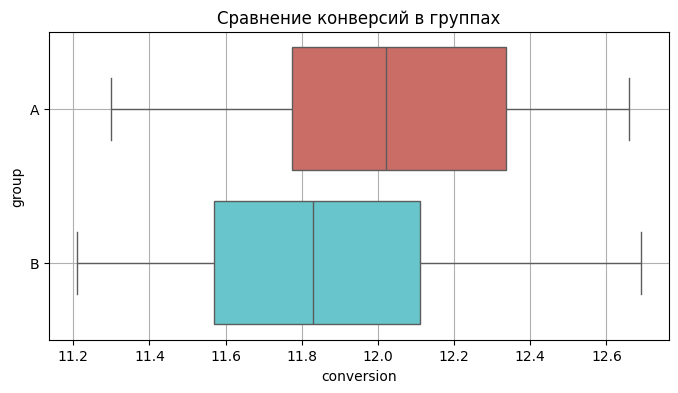

In [8]:
fig = plt.figure(figsize=(8, 4))
sns.boxplot(daily_data, x='conversion', y='group', palette='hls')
plt.title('Сравнение конверсий в группах')
plt.grid();

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

In [9]:
# Вычислим показатели средней и медианны.
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean' , 'median']
)
conversion_piv

,mean,median
group,,
A,12.033478,12.02
B,11.872174,11.83


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

## Комулятивные метрики

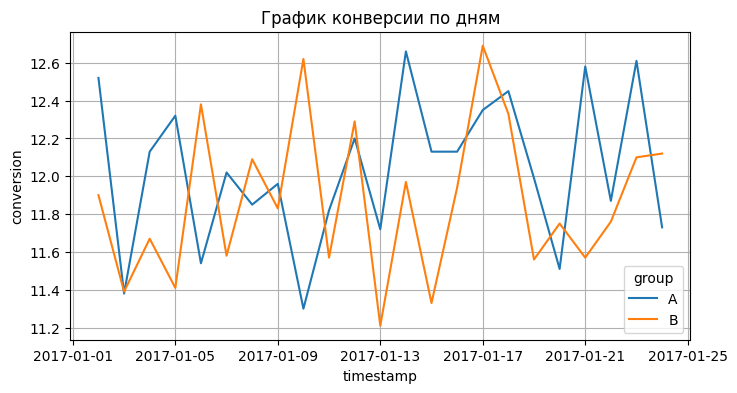

In [10]:
fig = plt.figure(figsize=(8, 4))
sns.lineplot(daily_data, x='timestamp', y='conversion', hue='group')
plt.title('График конверсии по дням')
plt.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [11]:
# Выделяем данные группы А.
daily_data_a = daily_data[daily_data['group'] == 'A']
# Считаем кумулятивное количество посетителей.
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# Выводим время, количество посетителей и кумулятивное количество посетителей.
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [12]:
# Вычисляем кумулятивную сумму количества посетителей.
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# Вычисляем кумулятивную сумму количества совершённых целевых действий.
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# Вычисляем кумулятивную конверсию.
daily_data['cum_conversion'] = daily_data['cum_converted'] / daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.52,2851,357,12.521922
1,2017-01-02,B,2848,339,11.90,2848,339,11.903090
2,2017-01-03,A,6584,749,11.38,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.39,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.13,16008,1903,11.887806


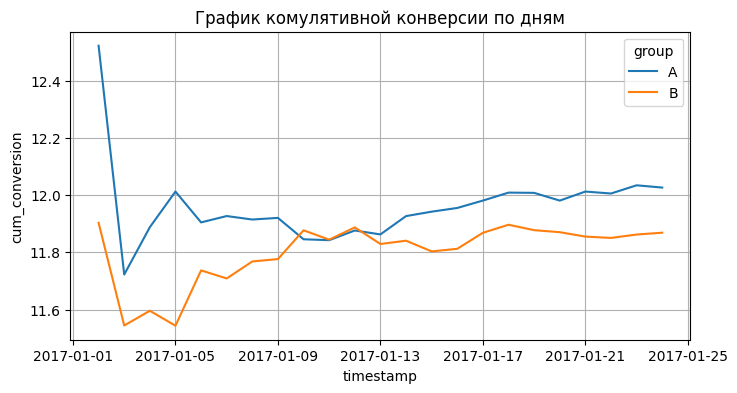

In [13]:
fig = plt.figure(figsize=(8, 4))
sns.lineplot(daily_data, x='timestamp', y='cum_conversion', hue='group')
plt.title('График комулятивной конверсии по дням')
plt.grid();

## Статистические тесты для конверсии

In [14]:
converted_piv = ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


Мы знаем, что группы независимые: пользователи в группах А и B не пересекаются. Значит, нам нужно воспользоваться либо Z- либо -критерием.

## Z-тест для пропорции

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): конверсии в группах *А* и *В* равны.
$$H_0 :p_a = p_b$$
*Альтернативная гипотеза* ($H_1$): конверсии в группах *А* и *В* не равны.
$$H_1 :p_a \neq p_b$$

In [15]:
alpha = 0.05 # уровень значимости

# Вычисляем значение p-value для z-теста для пропорций.
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='two-sided',
)
# Выводим результат на экран
print('p-value: ', round(p_value, 3))

# Сравниваем полученное p-value с уровнем значимости.
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


Так как Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза не подтверждается статистически.



Проверить гипотезу о том, что вариант А лучше варианта B по метрике конверсии. Тогда нам нужно переформулировать гипотезы таким образом, чтобы альтернативная гипотеза отражала наш бизнес-вопрос:

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): конверсия в группа *А* меньше или равна конверсии в группу *В*.
$$H_0 :p_a \leq p_b$$
*Альтернативная гипотеза* ($H_1$): конверсия в группе *А* больше, чем конверсия в круппе *В*.
$$H_1 :p_a > p_b$$

In [16]:
alpha = 0.05 # уровень значимости
# Вычисляем значение p-value для Z-теста для пропорций.
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# Выводим результат на экраню
print('p-value: ', round(p_value, 3))

# Сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.095
У нас нет оснований отвергнуть нулевую гипотезу


## $X^2$-тест для пропорций

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза* ($H_0$): конверсии в группах *А* и *В* равны.
$$H_0 :p_a = p_b$$
*Альтернативная гипотеза* ($H_1$): конверсии в группах *А* и *В* не равны.
$$H_1 :p_a \neq p_b$$

In [17]:
alpha = 0.05 # уровень значимости

# Вычисляем значение p-value для Х2-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'] # общее число наблюдений
)
# Выводим результат на экран
print('p-value: ', round(p_value, 3))

# Сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии.

**Возможные варианты, что делать дальше:**

- отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить текущую версию рекомендаций;
- попытаться усовершенствовать модель и провести тестирование снова;
- использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

In [ ]:
def